# Magic : The Gathering Card Detection

## Imports

In [1]:
# Import required packages
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
import json
import re
import imutils
import unicodedata
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Mention the installed location of Tesseract-OCR in system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

## Apply a perspective transform to rectify the image

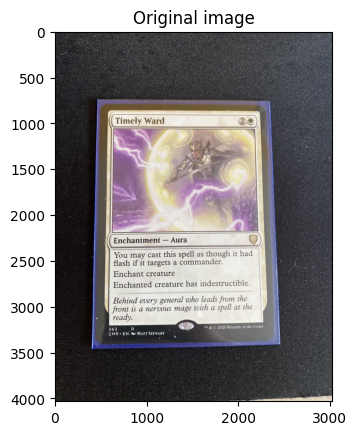

In [2]:
img_name = '1'

# Read image in either png or jpg format
img = cv2.imread('./cards/' + img_name + '.jpg')
if img is None:
    img = cv2.imread('./cards/' + img_name + '.png')

plt.title('Original image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

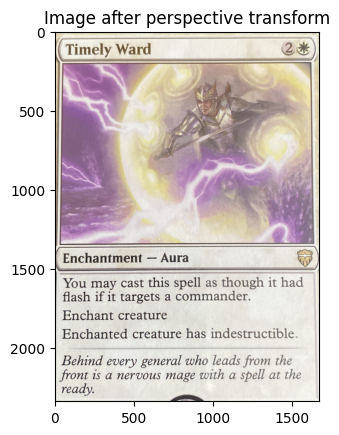

In [3]:
# Resize image to a height of 500 to speed up the process
ratio = img.shape[0] / 500.0
image_copy = img.copy()
image_copy = imutils.resize(image_copy, height = 500)

gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)

cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
for c in cnts:
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	if len(approx) == 4:
		screenCnt = approx
		break

def order_points(pts):
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect

def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	return warped

# Apply the four point transform to obtain a top-down view of the original image
warped = four_point_transform(img, screenCnt.reshape(4, 2) * ratio)

plt.title('Image after perspective transform')
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.show()

## Detect text

In [4]:
text = pytesseract.image_to_string(warped)
print(text)

as hs = |. pe ci oD

( Timely Ward

_ Enchantment — Aura

OM POSED ASTER AONE

You may cast this sell as fhousk it fade
flash if it targets a commander.

Enchant creature
Enchanted creature has indestructible.

Bend. every general who leads from the
front is a nervous mage with a spell at the

ready.



## Create the model

In [5]:
# Load the "cards.json" file into a pandas dataframe
with open('./data/cards.json', encoding='utf-8') as f:
    data = json.load(f)
df = pd.json_normalize(data)

# Preprocess the text data
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        # Remove accents
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        if not text:
            return ''
        return text
    return ''   

df['name_preprocessed'] = df['name'].apply(preprocess_text)
df['text_preprocessed'] = df['text'].apply(preprocess_text)

# Create TF-IDF vectorizers
vectorizer = TfidfVectorizer()

# Create vectorizer only for the name column
vectorizer_name = TfidfVectorizer()
vectorizer_name.fit(df['name_preprocessed'])

# Fit the vectorizer on the preprocessed text data
corpus = df['name_preprocessed'] + ' ' + df['text_preprocessed']
vectorizer.fit(corpus)

TfidfVectorizer()

## Find card

In [6]:
# Define a function to find the closest matches to the input text
def find_closest_match(input_text, vectorizer):
    input_text = preprocess_text(input_text)
    input_vector = vectorizer.transform([input_text])
    similarities = cosine_similarity(input_vector, vectorizer.transform(corpus))

    # Get the 5 closest matches that have different ids
    closest_match_ids = []
    while len(closest_match_ids) < 5:
        closest_match_id = df.iloc[np.argmax(similarities)]['id']
        if closest_match_id not in closest_match_ids:
            closest_match_ids.append(closest_match_id)
        similarities[0, np.argmax(similarities)] = 0

    return closest_match_ids

# Use the function to find the closest match to the input text and return the corresponding 'id'
input_text = text
closest_match_id = find_closest_match(input_text, vectorizer)

print("Top 5 closest matches :")
print("1: " + df[df['id'] == closest_match_id[0]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[0]]['uri'].values[0])
print("2: " + df[df['id'] == closest_match_id[1]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[1]]['uri'].values[0])
print("3: " + df[df['id'] == closest_match_id[2]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[2]]['uri'].values[0])
print("4: " + df[df['id'] == closest_match_id[3]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[3]]['uri'].values[0])
print("5: " + df[df['id'] == closest_match_id[4]]['name'].values[0] + " - " + df[df['id'] == closest_match_id[4]]['uri'].values[0])

Top 5 closest matches :
1: Rune de garde providentielle - https://scryfall.com/card/cmr/363/fr/rune-de-garde-providentielle?utm_source=api
2: Combat Research - https://scryfall.com/card/dmu/44/combat-research?utm_source=api
3: Parallax Dementia - https://scryfall.com/card/nem/62/parallax-dementia?utm_source=api
4: Pastenuage - https://scryfall.com/card/nem/29/fr/pastenuage?utm_source=api
5: Rune de garde des reliques - https://scryfall.com/card/vis/16/fr/rune-de-garde-des-reliques?utm_source=api
